## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle5 as pickle
import numpy as np

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    if split=="train" or split=="validation":
        f_in = ROOT_PATH + "train" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
        
        if split == "train":
            inputs = inputs[:inputs.shape[0]*4//5]
        else:
            inputs = inputs[inputs.shape[0]*4//5:]
        
        f_out = ROOT_PATH + "train" + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)
        if split == "train":
            outputs = outputs[:outputs.shape[0]*4//5]
        else:
            outputs = outputs[outputs.shape[0]*4//5:]
    else:
        f_in = ROOT_PATH + "test" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        inputs = np.asarray(inputs)
        outputs = None

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
def transform(data):
    # currently 109 input - 109 out
    inp = np.concatenate((data[0], data[1][:-1]))
    out = np.concatenate((data[0][1:], data[1]))
    return (inp, out)
train_dataset  = ArgoverseDataset(city = city, split = split, transform=transform)
print(train_dataset[0][0][1:10] == train_dataset[0][1][:9])

[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


## Create a DataLoader class for training

In [3]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle=True)

## Sample a batch of data and visualize 

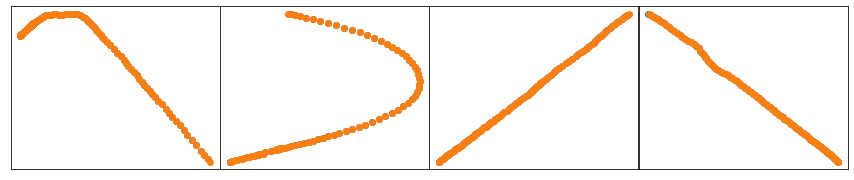

In [4]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch <= 5:
        continue
    inp, out = sample_batch
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

# Model Training

val_loss: -1.000, train_loss: -1.000, epoch #0: 2399it [00:14, 160.53it/s]
val_loss: 2171438.750, train_loss: 2119179.325, epoch #1: 930it [00:05, 168.35it/s]


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

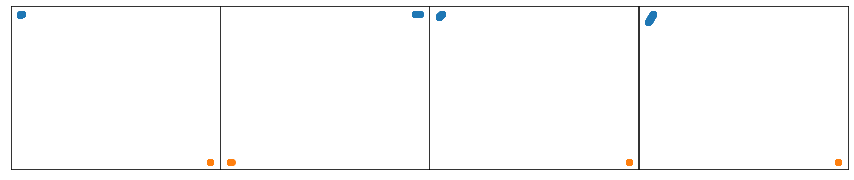

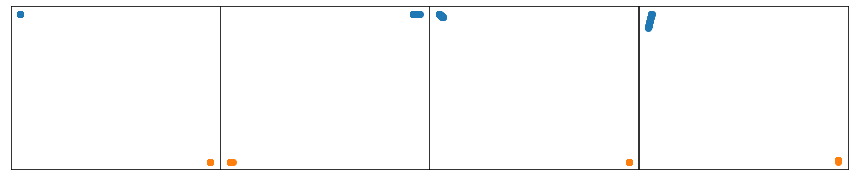

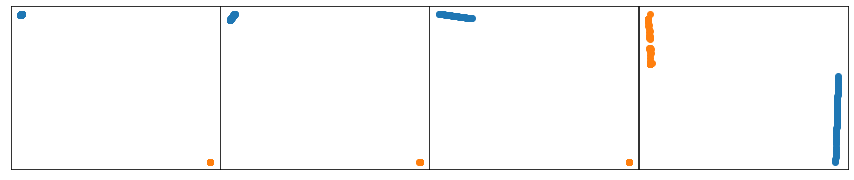

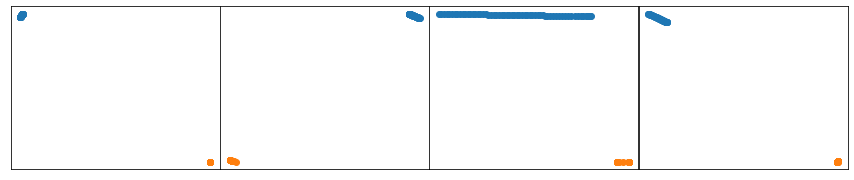

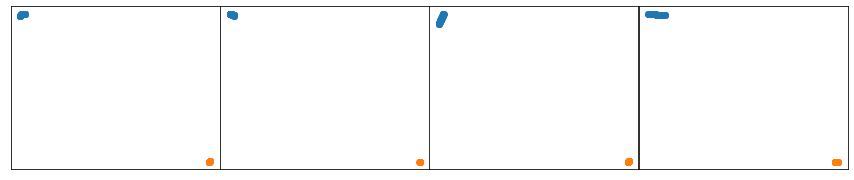

In [10]:
from models import LSTM
from tqdm import tqdm

val_dataset = ArgoverseDataset(city = city, split = "validation")
#TODO set batch size
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
val_iter = iter(val_loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = 2
hidden_size = 64
output_size = 2
inp_seq_len = 50

rnn = LSTM(input_size, hidden_size, output_size, device).cuda()
criterion = torch.nn.MSELoss()
opt = torch.optim.Adam(rnn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

num_epochs = 80
display_every = 1000
plot_every = 500
current_loss = 0
train_losses = [-1]
val_losses = [-1]
fig = plt.figure()

rnn.train()
for epoch in range(num_epochs):
    current_loss = 0
    for s_num, (x, y) in tqdm(enumerate(train_loader), \
                              "val_loss: %.3f, train_loss: %.3f, epoch #%d" % (val_losses[-1], train_losses[-1], epoch)):
        x, y = x.to(torch.float32).to(device), y.to(torch.float32).to(device)
        
        opt.zero_grad()
        loss = 0
        
        y_hat = rnn(x)
        loss = criterion(y_hat, y)
        
        loss.backward()
        opt.step()
        
        # Display training examples every so often
#         if s_num % display_every == 0:
#             with torch.no_grad():
#                 show_sample_batch((y[:4].cpu(), y_hat[:4].cpu()))
                
#                 rnn.eval()
#                 vx, vy = next(val_iter)
#                 vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
#                 vy_hat = rnn(vx)
#                 val_losses.append(criterion(vy_hat, vy))
#                 show_sample_batch((vy[:4].cpu(), vy_hat[:4].cpu()))
#                 del vx
#                 del vy
#                 rnn.train()
        
        # Keep track of average losses
        current_loss += loss.item()
        if s_num != 0 and s_num % plot_every == 0:
            with torch.no_grad():
                train_losses.append(current_loss / plot_every)
                current_loss = 0
                
                rnn.eval()
                vx, vy = next(val_iter)
                vx, vy = vx.to(torch.float32).to(device), vy.to(torch.float32).to(device)
                vy_hat = rnn(vx)
                val_losses.append(criterion(vy_hat, vy))
                show_sample_batch((vy[:4].cpu(), vy_hat[:4].cpu()))
                del vx
                del vy
                rnn.train()
                
        
        del x
        del y
    scheduler.step(val_losses[-1])
        

# Examining the submission format

In [8]:
import pandas as pd

In [10]:
sample_sub = pd.read_csv('./argo2/sample_submission.csv')
sample_sub.head()

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4_austin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from prediction import get_traj_pred

ModuleNotFoundError: No module named 'prediction'

In [11]:
num_pred_steps = 60
all_preds = np.zeros(shape=(0, num_pred_steps * 2))
city_col = np.array([])

for city_name in cities:

    print("Processing city", city_name)
    
    test_traj_in, test_traj_out = get_city_trajectories(city=city_name, split="test")
    print(test_traj_in.shape)

    test_pred_arr = np.random.rand(test_traj_in.shape[0], 60, 2)
    print(test_pred_arr.shape)
    
    test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
    print(test_pred_arr_reshaped.shape)

    all_preds = np.r_[all_preds, test_pred_arr_reshaped]
    city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]

Processing city austin
(6325, 50, 2)
(6325, 60, 2)
(6325, 120)
Processing city miami
(7971, 50, 2)
(7971, 60, 2)
(7971, 120)
Processing city pittsburgh
(6361, 50, 2)
(6361, 60, 2)
(6361, 120)
Processing city dearborn
(3671, 50, 2)
(3671, 60, 2)
(3671, 120)
Processing city washington-dc
(3829, 50, 2)
(3829, 60, 2)
(3829, 120)
Processing city palo-alto
(1686, 50, 2)
(1686, 60, 2)
(1686, 120)


In [12]:
sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
sub_df.to_csv('./submissions/Neelay_test_1.csv', index=None)